In [ ]:
from time import time
from importlib import reload

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegressionCV

import utils
from structuremap.processing import get_smooth_score

import matplotlib.pyplot as plt
import seaborn as sns

## Load and merge ground-truth labels of disorder (Y) with Alphafold-based accessibility scores (used to train f(X))

`idr-groundtruth.csv`, which contains per-residue ground-truth disordered/ordered labels, is equivalent to the "groundtruth_data" dataframe computed
in the following notebook from [Isabell Bludau et al. (2022), PLOS Biology](https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.3001636):
https://github.com/MannLabs/structuremap_analysis/blob/master/IDR_benchmark.ipynb

`accessibility_df`, which contains per-residue scores of structural accessibility scores based on Alphafold-predicted structures, is equivalent to the "accessibility_df" dataframe computed in the same notebook.

`rsa_df` contains per-residue relative solvent-accessible surface area (RSA, computed using biopython's [PDB.DSSP module](https://biopython.org/docs/1.75/api/Bio.PDB.DSSP.html)) based on Alphafold-predicted structures and is equivalent to the "RSA_data" dataframe.

Both the accessibility and RSA scores are Alphafold-based scores that can be used to predict disorder.

In [2]:
idr_df = pd.read_csv('data/idr-groundtruth.csv')
idr_df

,protein_id,position,disordered,ordered
0,P49913,134,1.0,0.0
1,P49913,135,1.0,0.0
2,P49913,136,1.0,0.0
3,P49913,137,1.0,0.0
4,P49913,138,1.0,0.0
...,...,...,...,...
485034,P30519,232,0.0,1.0
485035,P30519,233,0.0,1.0
485036,P30519,234,0.0,1.0
485037,P30519,235,0.0,1.0


In [3]:
# accessibility score, termed prediction-aware part-sphere exposure (pPSE) in the main paper
# (Bludau et al., 2022) is computed with a range of hyperparameter settings:
# 12, 16, 20, 24, and 28-angstrom radii around each amino acid

# TODO: double-check Bludau version has more HPs?
accessibility_df = pd.read_csv('data/accessibility_df.csv')
accessibility_df

,protein_id,AA,position,nAA_12_180_nopae,nAA_12_180_pae,nAA_16_180_nopae,nAA_16_180_pae,nAA_20_180_nopae,nAA_20_180_pae,nAA_24_180_nopae,nAA_24_180_pae,nAA_28_180_nopae,nAA_28_180_pae
0,A1A4S6,M,1,5,2,16,3,34,3,52,7,78,11
1,A1A4S6,G,2,9,3,29,9,48,17,72,28,93,41
2,A1A4S6,L,3,20,10,36,21,60,36,83,56,101,72
3,A1A4S6,Q,4,19,10,36,24,52,39,76,51,95,73
4,A1A4S6,P,5,23,12,42,32,58,44,81,59,98,80
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1622132,Q9ZWM9,I,340,6,4,8,6,10,8,11,9,14,10
1622133,Q9ZWM9,F,341,6,4,7,6,8,7,10,8,12,9
1622134,Q9ZWM9,H,342,5,4,6,5,7,6,9,7,11,8
1622135,Q9ZWM9,A,343,4,3,5,3,6,5,8,6,10,7


In [4]:
rsa_df = pd.read_csv('data/RSA_data.csv')
rsa_df

,protein_id,AA,position,RSA,neg_RSA
0,Q9BUK0,M,1,1.000000,0.000000
1,Q9BUK0,P,2,0.529412,0.470588
2,Q9BUK0,S,3,0.469231,0.530769
3,Q9BUK0,V,4,0.774648,0.225352
4,Q9BUK0,T,5,0.626761,0.373239
...,...,...,...,...,...
1622132,P07273,R,305,0.629032,0.370968
1622133,P07273,W,306,0.251101,0.748899
1622134,P07273,K,307,0.746341,0.253659
1622135,P07273,F,308,0.573604,0.426396


In [5]:
# combine accessibility and RSA scores (both Alphafold-based scores that are correlated with disorder)
# into one dataframe
scores_df = accessibility_df.merge(
    rsa_df, how='inner', on=['protein_id', 'position', 'AA']
)
print('{} residues from {} proteins'.format(len(scores_df), len(set(scores_df.protein_id))))

1618857 residues from 3062 proteins


Smooth scores over sliding windows of residues

In [6]:
# need dummy protein_number column to run get_smooth_score
protein_ids = sorted(scores_df.protein_id.unique())
id2number = {pid: i for i, pid in enumerate(protein_ids)}
protein_number_col = [id2number[pid] for pid in scores_df.protein_id]
scores_df['protein_number'] = protein_number_col
scores_df

,protein_id,AA,position,nAA_12_180_nopae,nAA_12_180_pae,nAA_16_180_nopae,nAA_16_180_pae,nAA_20_180_nopae,nAA_20_180_pae,nAA_24_180_nopae,nAA_24_180_pae,nAA_28_180_nopae,nAA_28_180_pae,RSA,neg_RSA,protein_number
0,A1A4S6,M,1,5,2,16,3,34,3,52,7,78,11,1.000000,0.000000,0
1,A1A4S6,G,2,9,3,29,9,48,17,72,28,93,41,0.809524,0.190476,0
2,A1A4S6,L,3,20,10,36,21,60,36,83,56,101,72,0.390244,0.609756,0
3,A1A4S6,Q,4,19,10,36,24,52,39,76,51,95,73,0.585859,0.414141,0
4,A1A4S6,P,5,23,12,42,32,58,44,81,59,98,80,0.514706,0.485294,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1618852,Q9ZWM9,I,340,6,4,8,6,10,8,11,9,14,10,1.000000,0.000000,3061
1618853,Q9ZWM9,F,341,6,4,7,6,8,7,10,8,12,9,0.878173,0.121827,3061
1618854,Q9ZWM9,H,342,5,4,6,5,7,6,9,7,11,8,0.978261,0.021739,3061
1618855,Q9ZWM9,A,343,4,3,5,3,6,5,8,6,10,7,0.839623,0.160377,3061


In [9]:
scores_to_smooth = np.array(
    ['neg_RSA', 'nAA_12_180_pae', 'nAA_16_180_pae', 'nAA_20_180_pae', 'nAA_24_180_pae', 'nAA_28_180_pae']
)
smoothedscores_df = get_smooth_score(scores_df, scores_to_smooth, [5, 10, 15, 20, 25, 30, 35])

100%|█████████████████████████████████████████████████████████████████████████████████████████| 3062/3062 [00:39<00:00, 77.65it/s]


In [10]:
# merge with ground-truth disorder labels
idr_scores_df = smoothedscores_df.merge(idr_df, how='inner', on=['protein_id', 'position'])
print('{} residues from {} proteins with ground-truth IDR labels and Alphafold-based scores'.format(
    len(idr_scores_df), len(set(idr_scores_df.protein_id))))
idr_scores_df

478818 residues from 3062 proteins with ground-truth IDR labels and Alphafold-based scores


,protein_id,AA,position,nAA_12_180_nopae,nAA_12_180_pae,nAA_16_180_nopae,nAA_16_180_pae,nAA_20_180_nopae,nAA_20_180_pae,nAA_24_180_nopae,...,nAA_24_180_pae_smooth35,nAA_28_180_pae_smooth5,nAA_28_180_pae_smooth10,nAA_28_180_pae_smooth15,nAA_28_180_pae_smooth20,nAA_28_180_pae_smooth25,nAA_28_180_pae_smooth30,nAA_28_180_pae_smooth35,disordered,ordered
0,A1A4S6,I,728,12,4,21,6,39,9,56,...,29.943662,28.636364,31.380952,31.838710,32.268293,32.588235,33.065574,33.267606,0.0,1.0
1,A1A4S6,R,729,12,4,22,7,41,10,61,...,30.422535,32.818182,33.476190,33.129032,33.341463,33.490196,33.836066,33.859155,0.0,1.0
2,A1A4S6,S,730,16,6,33,9,48,14,64,...,31.028169,36.909091,35.523810,34.548387,34.414634,34.392157,34.590164,34.478873,0.0,1.0
3,A1A4S6,R,731,21,11,40,17,58,26,68,...,31.676056,41.000000,37.523810,35.967742,35.463415,35.313725,35.344262,35.126761,0.0,1.0
4,A1A4S6,K,732,23,16,45,29,58,46,66,...,32.338028,45.000000,39.428571,37.387097,36.512195,36.254902,36.049180,35.774648,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478813,Q9ZWM9,G,299,14,4,19,7,26,8,44,...,33.507042,14.181818,22.238095,34.129032,33.634146,36.627451,39.737705,40.901408,0.0,1.0
478814,Q9ZWM9,R,300,13,4,22,5,31,9,48,...,32.661972,14.000000,18.714286,31.193548,33.121951,34.745098,38.557377,39.845070,0.0,1.0
478815,Q9ZWM9,V,301,13,4,19,6,24,12,39,...,31.915493,13.909091,16.142857,28.258065,32.804878,32.960784,37.196721,38.915493,0.0,1.0
478816,Q9ZWM9,L,302,12,4,18,10,26,12,37,...,31.070423,14.181818,15.095238,25.225806,31.853659,31.333333,35.704918,37.816901,0.0,1.0


## Fit predictive model of per-residue disorder

The dataset with ground-truth IDR labels has some intersection with the dataset of ground-truth PTM labels. We will use this intersection to perform our prediction-powered inference experiments on (see other notebook). We now use the portion of the IDR dataset not intersecting with the PTM dataset (that is, IDR \ PTM) to fit a logistic regression model that maps the smoothed Alphafold-based accessibility scores computed above to a binary prediction of disorder.

In [11]:
ptm_df = pd.read_csv('data/phosphositeplus_annotation.csv')
print('{} residues from {} proteins with ground-truth PTM labels'.format(
    len(ptm_df), len(set(ptm_df.protein_id))
))
ptm_df

369211 residues from 20938 proteins with ground-truth PTM labels


,protein_id,AA,position,ac,ac_reg,ga,gl,gl_reg,m,m_reg,p,p_reg,sm,sm_reg,ub,ub_reg
0,A0A024R5B6,K,43,0,0,0,0,0,0,0,0,0,0,0,1,1
1,A0A024RBG1,K,128,0,0,0,0,0,0,0,0,0,0,0,1,0
2,A0A024RBG1,K,134,0,0,0,0,0,0,0,0,0,0,0,1,0
3,A0A024RBG1,K,143,0,0,0,0,0,0,0,0,0,0,0,1,0
4,A0A024RBG1,K,5,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369206,Q9Y6Z7,K,97,1,0,0,0,0,0,0,0,0,0,0,0,0
369207,Q9Y6Z7,S,141,0,0,0,0,0,0,0,1,0,0,0,0,0
369208,Q9Y6Z7,T,155,0,0,0,0,0,0,0,1,0,0,0,0,0
369209,Q9YNA8,S,465,0,0,0,0,0,0,0,1,0,0,0,0,0


In [12]:
# extract IDR data that does not have PTM labels
ptm_names = list(set(ptm_df.columns).difference(set(idr_scores_df)))
idr_noptm_df = idr_scores_df.merge(ptm_df, indicator=True, how="left")[lambda x: x._merge=='left_only']
idr_noptm_df.drop(['_merge'] + ptm_names, axis=1, inplace=True)
print('{} residues from {} proteins with IDR labels and Alphafold-based scores'.format(
    len(idr_scores_df), len(set(idr_scores_df.protein_id))))
print('{} residues from {} proteins with IDR labels and Alphafold-based scores but no PTM labels'.format(
    len(idr_noptm_df), len(set(idr_noptm_df.protein_id))
))
idr_noptm_df

478818 residues from 3062 proteins with IDR labels and Alphafold-based scores
468016 residues from 3062 proteins with IDR labels and Alphafold-based scores but no PTM labels


,protein_id,AA,position,nAA_12_180_nopae,nAA_12_180_pae,nAA_16_180_nopae,nAA_16_180_pae,nAA_20_180_nopae,nAA_20_180_pae,nAA_24_180_nopae,...,nAA_24_180_pae_smooth35,nAA_28_180_pae_smooth5,nAA_28_180_pae_smooth10,nAA_28_180_pae_smooth15,nAA_28_180_pae_smooth20,nAA_28_180_pae_smooth25,nAA_28_180_pae_smooth30,nAA_28_180_pae_smooth35,disordered,ordered
0,A1A4S6,I,728,12,4,21,6,39,9,56,...,29.943662,28.636364,31.380952,31.838710,32.268293,32.588235,33.065574,33.267606,0.0,1.0
1,A1A4S6,R,729,12,4,22,7,41,10,61,...,30.422535,32.818182,33.476190,33.129032,33.341463,33.490196,33.836066,33.859155,0.0,1.0
2,A1A4S6,S,730,16,6,33,9,48,14,64,...,31.028169,36.909091,35.523810,34.548387,34.414634,34.392157,34.590164,34.478873,0.0,1.0
3,A1A4S6,R,731,21,11,40,17,58,26,68,...,31.676056,41.000000,37.523810,35.967742,35.463415,35.313725,35.344262,35.126761,0.0,1.0
4,A1A4S6,K,732,23,16,45,29,58,46,66,...,32.338028,45.000000,39.428571,37.387097,36.512195,36.254902,36.049180,35.774648,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478813,Q9ZWM9,G,299,14,4,19,7,26,8,44,...,33.507042,14.181818,22.238095,34.129032,33.634146,36.627451,39.737705,40.901408,0.0,1.0
478814,Q9ZWM9,R,300,13,4,22,5,31,9,48,...,32.661972,14.000000,18.714286,31.193548,33.121951,34.745098,38.557377,39.845070,0.0,1.0
478815,Q9ZWM9,V,301,13,4,19,6,24,12,39,...,31.915493,13.909091,16.142857,28.258065,32.804878,32.960784,37.196721,38.915493,0.0,1.0
478816,Q9ZWM9,L,302,12,4,18,10,26,12,37,...,31.070423,14.181818,15.095238,25.225806,31.853659,31.333333,35.704918,37.816901,0.0,1.0


Fit logistic regression mapping each accessibility score to predicted disorder. For each score, set regularization hyperparameter based on 5-fold CV. Select score with lowest CV MSE (variance of Y - f).

In [29]:
Cs = np.logspace(-3, 8, 12)
max_iter = 500
k = 5

# variance of Y - f
def neg_mse(estimator, X, y):
    pred_nx2 = estimator.predict_proba(X)
    y[y == -1] = 0  # LogisticRegressionCV preprocesses 0s to -1s under the hood
    assert(((y == 0) | (y == 1)).all())
    return -np.mean(np.square(y - pred_nx2[:, 1]))

# for each score, fit logistic regression to predict disorder
lr = LogisticRegressionCV(
    Cs=Cs, fit_intercept=True, cv=k, max_iter=max_iter, penalty='l2', scoring=neg_mse)
score_names = [name for name in idr_noptm_df.columns if 'smooth' in name]
mse_s = []
for name in score_names:
    shuffle_idx = np.random.permutation(len(idr_noptm_df))
    x_nx1 = idr_noptm_df[name].to_numpy()[shuffle_idx, None]
    # x_nx1 = x_nx1 / np.std(x_nx1)
    y_n = idr_noptm_df['disordered'].to_numpy()[shuffle_idx]
    lr.fit(x_nx1, y_n)
    score = np.max(np.mean(lr.scores_[1.0], axis=0))
    mse_s.append(score)
    print('{} CV MSE: {:.4f}. Regularization: {}. Scale: {:.2f}. Shift: {:.2f}'.format(
        name, score, lr.C_[0], lr.coef_[0, 0], lr.intercept_[0]))
    
# select best score
score_name = score_names[np.argmax(mse_s)]

# fit logistic regression to best score again
final_lr = LogisticRegressionCV(
    Cs=Cs, fit_intercept=True, cv=k, max_iter=max_iter, penalty='l2', scoring=neg_mse, refit=True)
shuffle_idx = np.random.permutation(len(idr_noptm_df))
x_n = idr_noptm_df[score_name].to_numpy()[shuffle_idx, None]
y_n = idr_noptm_df['disordered'].to_numpy()[shuffle_idx]
final_lr.fit(x_n, y_n)
print('\nSelecting {} with CV MSE {:.4f}. Scale: {:.2f}. Shift: {:.2f}'.format(
    score_name, np.max(mse_s), final_lr.coef_[0, 0], final_lr.intercept_[0]))
np.savez('model_coefs.npz', scale=final_lr.coef_[0, 0], shift=final_lr.intercept_[0])

neg_RSA_smooth5 CV MSE: -0.0419. Regularization: 100000000.0. Scale: -10.76. Shift: 3.07
neg_RSA_smooth10 CV MSE: -0.0370. Regularization: 100000000.0. Scale: -12.05. Shift: 3.80
neg_RSA_smooth15 CV MSE: -0.0347. Regularization: 10000000.0. Scale: -12.90. Shift: 4.23
neg_RSA_smooth20 CV MSE: -0.0335. Regularization: 10000000.0. Scale: -13.51. Shift: 4.53
neg_RSA_smooth25 CV MSE: -0.0328. Regularization: 10000000.0. Scale: -13.98. Shift: 4.74
neg_RSA_smooth30 CV MSE: -0.0325. Regularization: 10000000.0. Scale: -14.34. Shift: 4.90
neg_RSA_smooth35 CV MSE: -0.0325. Regularization: 10000000.0. Scale: -14.60. Shift: 5.01
nAA_12_180_pae_smooth5 CV MSE: -0.0485. Regularization: 10.0. Scale: -0.41. Shift: 2.33
nAA_12_180_pae_smooth10 CV MSE: -0.0412. Regularization: 10.0. Scale: -0.47. Shift: 3.03
nAA_12_180_pae_smooth15 CV MSE: -0.0379. Regularization: 10.0. Scale: -0.50. Shift: 3.45
nAA_12_180_pae_smooth20 CV MSE: -0.0362. Regularization: 10.0. Scale: -0.52. Shift: 3.72
nAA_12_180_pae_smooth

In [31]:
# extract intersection of IDR and PTM datasets
ptm_idr_df = ptm_df.merge(
    idr_scores_df, how='inner', on=['protein_id', 'position', 'AA']
)
print('{} residues from {} proteins with PTM and IDR labels and Alphafold-based accessibility scores'.format(
    len(ptm_idr_df), len(set(ptm_idr_df.protein_id))))

10802 residues from 1368 proteins with PTM and IDR labels and Alphafold-based accessibility scores


In [ ]:
# predict disorder using final logistic regression model and save
pred_n = final_lr.predict_proba(ptm_idr_df[score_name].to_numpy()[:, None])[:, 1]
ptm_idr_df['pred_disordered'] = pred_n
ptm_idr_df.to_csv('data/ptm_idr.csv', index=False)

## Predictive performance per PTM

In [49]:
print('Diagonals of confusion matrix for disorder prediction, conditioned on PTM/no PTM:\n')
reload(utils)
for name in ptm_names:
    z1_df = ptm_idr_df.loc[ptm_idr_df[name] == 1]
    z1conf_2x2 = utils.get_confusion_matrix(z1_df, 'pred_disordered', 'disordered')
    z0_df = ptm_idr_df.loc[ptm_idr_df[name] == 0]
    z0conf_2x2 = utils.get_confusion_matrix(z0_df, 'pred_disordered', 'disordered')
    print('PTM = {} (n = {})'.format(name, len(z1_df)))
    print('  PTM: {:.3}, {:.3}'.format(*np.diag(z1conf_2x2)))
    print(' none: {:.3}, {:.3}\n'.format(*np.diag(z0conf_2x2)))

Diagonals of confusion matrix for disorder prediction, conditioned on PTM/no PTM:

PTM = p (n = 6017)
  PTM: 0.799, 0.972
 none: 0.618, 0.987

PTM = ga (n = 47)
  PTM: 0.333, 0.909
 none: 0.746, 0.98

PTM = m (n = 442)
  PTM: 0.635, 0.986
 none: 0.75, 0.979

PTM = gl (n = 23)
  PTM: 0.812, 0.857
 none: 0.745, 0.979

PTM = ac_reg (n = 68)
  PTM: 0.639, 0.781
 none: 0.747, 0.98

PTM = gl_reg (n = 3)
  PTM: 1.0, 1.0
 none: 0.745, 0.979

PTM = ub_reg (n = 66)
  PTM: 0.848, 1.0
 none: 0.743, 0.979

PTM = p_reg (n = 663)
  PTM: 0.859, 0.937
 none: 0.723, 0.981

PTM = sm_reg (n = 56)
  PTM: 0.885, 0.967
 none: 0.743, 0.979

PTM = sm (n = 361)
  PTM: 0.711, 0.968
 none: 0.747, 0.98

PTM = ub (n = 3738)
  PTM: 0.591, 0.993
 none: 0.782, 0.97

PTM = ac (n = 1171)
  PTM: 0.649, 0.974
 none: 0.756, 0.98

PTM = m_reg (n = 11)
  PTM: 1.0, 0.8
 none: 0.745, 0.979



ROC curve

In [4]:
df = pd.read_csv('data/ptm_idr.csv', index_col=0)
df

,AA,position,ac,ac_reg,ga,gl,gl_reg,m,m_reg,p,...,nAA_28_180_pae_smooth5,nAA_28_180_pae_smooth10,nAA_28_180_pae_smooth15,nAA_28_180_pae_smooth20,nAA_28_180_pae_smooth25,nAA_28_180_pae_smooth30,nAA_28_180_pae_smooth35,disordered,ordered,pred_disordered
protein_id,,,,,,,,,,,,,,,,,,,,,
O00151,K,22,1,0,0,0,0,0,0,0,...,72.818182,77.428571,74.774194,74.951220,75.319149,76.500000,76.877193,0.0,1.0,0.022424
O00151,K,71,0,0,0,0,0,0,0,0,...,75.000000,77.809524,72.483871,67.268293,64.294118,61.786885,59.450704,0.0,1.0,0.057403
O00151,K,87,0,0,0,0,0,1,0,0,...,33.000000,41.095238,41.419355,43.170732,43.764706,43.491803,44.070423,0.0,1.0,0.245860
O00151,T,34,0,0,0,0,0,0,0,1,...,80.727273,78.380952,79.193548,80.560976,77.980392,77.754098,76.695652,0.0,1.0,0.017603
O00168,S,82,0,0,0,0,0,0,0,1,...,18.454545,16.761905,16.384615,16.806452,17.638889,19.756098,22.000000,0.0,1.0,0.433978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Y6W3,S,697,0,0,0,0,0,0,0,1,...,101.818182,105.047619,103.870968,113.097561,115.352941,124.655738,129.366197,0.0,1.0,0.006763
Q9Y6W3,S,700,0,0,0,0,0,0,0,1,...,93.454545,98.857143,102.258065,110.756098,110.725490,121.901639,129.845070,0.0,1.0,0.006944
Q9Y6W6,K,380,0,0,0,0,0,0,0,0,...,114.909091,129.333333,127.290323,123.536585,124.137255,128.213115,129.056338,0.0,1.0,0.004483


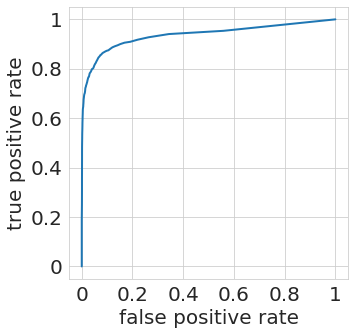

In [28]:
thresholds = np.arange(0, 1, 1e-2)
p_df = df.loc[df['disordered'] == 1]
n_df = df.loc[df['disordered'] == 0]
tp = [len(p_df[p_df['pred_disordered'] >= t]) / len(p_df) for t in thresholds]
fp = [len(n_df[n_df['pred_disordered'] >= t]) / len(n_df) for t in thresholds]

fig, ax = plt.subplots(figsize=(5, 5))
sns.set_style(style="whitegrid")
ax.plot(fp, tp, linewidth=2)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=20)
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=20)
ax.set_xlabel('false positive rate', fontsize=20);
ax.set_ylabel('true positive rate', fontsize=20)
plt.savefig('./figures/predictions.pdf', dpi=300, bbox_inches='tight')